In [1]:
# Standard libraries
import time
import glob
import math
import numpy as np
import matplotlib.pyplot as plt

# SymPy for symbolic mathematics
import sympy
from sympy import symbols, exp, re, im, I, E

# Scikit-learn for machine learning utilities
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import cohen_kappa_score, f1_score

# SciPy for mathematical optimizations and special functions
from scipy.optimize import minimize
from scipy.special import pro_ang1

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Flatten, Cropping1D, Concatenate, MaxPooling1D, Dropout, 
    Reshape, Conv1D, BatchNormalization, Activation, AveragePooling1D, 
    GlobalAveragePooling1D, Lambda, Input, Add, UpSampling1D, Multiply
)
from tensorflow.keras.losses import (
    mean_squared_error, Hinge, binary_crossentropy, categorical_crossentropy
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, 
    LearningRateScheduler, Callback
)



2025-01-31 21:38:00.019920: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 21:38:00.021322: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 21:38:00.048693: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 21:38:00.049428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-31 21:38:02.194265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Definimos el valor de K

def Archit(K):

# We create an arrange with K values
    Array = np.arange(1, K[0] + 1)

# e create an arrange of the form (j, K * j)
    Lay_x_Neu = np.column_stack((Array, K[1] * Array))

    return Lay_x_Neu

In [3]:
# Number of samples and parameters

# Set maximum order for Slepian functions
max_order_slep = 35  # Consider increasing to 20 or more eventually

# Generate number of training samples (logarithmic scale from 100 to 10,000)
Nsamples = np.logspace(2, np.log10(10000), 10).astype(int)

# Set the number of test samples
Ntest = 1000

# Generate the order of Slepian functions, spanning from 1 to max_order_slep
Para_slep = np.linspace(1, max_order_slep + 1, 10).astype(int)

# Define the total number of runs for experimentation
total_runs = 20

In [ ]:
# This function generates 't' random values uniformly distributed between -1 and 1,
def samps(t):
       
    Values = np.random.uniform(-1, 1, t)
    

    
    return Values

In [4]:
# Define the samples 
def samps(t):
    """
    Generates a set of random values uniformly distributed between -1 and 1.
    
    Parameters:
    t : int, or list/array-like
        If t is an integer, generates 't' random values.
        If t is a list or array, generates random values for each element in 't'.
    
    Returns:
    Values : ndarray
        The generated random values uniformly distributed between -1 and 1.
    """
    
    # If t is a list or array, we use its first element as the size.
    if isinstance(t, (list, np.ndarray)):
        size = int(t[0])  # Use the first element of the list or array as the size
    else:
        size = int(t)  # Otherwise, assume t is a scalar representing the size
        
    # Generate random values uniformly between -1 and 1
    Values = np.random.uniform(-1, 1, size)
    
    return Values


In [5]:
#Returns the Slepian basis function

def NorSlep(j, c):
    b = 0 # Alpha parameter for the PSAF
    theta = np.linspace(-1, 1, 200)
    
    psaf_values = pro_ang1(b, j, c, theta)
    psaf_values = psaf_values[0] 
    
    psaf_values = psaf_values[1:199]
    l2_norm = np.linalg.norm(psaf_values)/np.sqrt(len(theta)-1)
    
    
    return l2_norm

norms_ = np.zeros([Para_slep[-1]])
for k in range(Para_slep[-1]):
    norms_[k] = NorSlep(k, 16)


In [6]:
#Compute the PSWF with j and c at the value x.

def PSWF(x, j, c):
    
    b = 0 # Alpha parameter for the PSAF
    
    # Calculate the PSAF values for the two modes
    psaf_values = pro_ang1(b, j, c, x)
    psaf_values = psaf_values[0] 
    
    
  
    l2_norm = norms_[j]
    
    return psaf_values/l2_norm 


In [7]:
#We know create the matrix for the ls approximation

def Matrix(samp, ordens):

    A= np.zeros((len(samp), ordens))
    #We create the matrix for the least square
    for j in range(ordens):
        for k in range(len(samp)):
            A[k,j]= PSWF(samp[k], j, 16)
    
    return A

In [8]:
#This is the function that we approximate
def funct(x):
    # t is the variable
    g = np.cos(10*x)*np.exp(-np.pi*x**2)
    
    return g 


In [1]:
import numpy as np

# Initialize the error vector
MSE = np.zeros([len(Para_slep), len(Nsamples), total_runs])

start_time = time.time()
total_iterations = total_runs * len(Para_slep) * len(Nsamples)
counter = 0

# test set can be the same always

for run in range(total_runs):
    # produce the matrix first, then take rectangles. It takes too long to recreate it every time.
    SamSet_ = samps(Nsamples[-1])
    y_ = funct(SamSet_)
    A_ = Matrix(SamSet_, Para_slep[-1])
    TestSet = samps(Ntest)
    Values_test = funct(TestSet)
    test_PSWF_matrix_ = np.array([[PSWF(t, i, 16) for i in range(Para_slep[-1])] for t in TestSet])    


    for orde in range(len(Para_slep)):
        
        for k in range(len(Nsamples)):
            # Generate sample and test sets
            A = A_[:Nsamples[k], :Para_slep[orde]]
            SamSet = SamSet_[:Nsamples[k]]
            y = y_[:Nsamples[k]]
            
            test_PSWF_matrix = test_PSWF_matrix_[:, :Para_slep[orde]]
            
            #Values_test = funct(TestSet)

            # Solve the linear regression problem using lstsq (least squares)
            x, _, _, _ = np.linalg.lstsq(A.T@A, A.T@y, rcond=None)

            # Calculate the linear combination on the test set in a vectorized manner
            linear_combination_t = test_PSWF_matrix@x
            
            # Calculate the error
            Err = np.linalg.norm(linear_combination_t - Values_test) / np.sqrt(Ntest)
            
            MSE[orde, k, run] = Err
            
            counter += 1
            now_time = time.time()
            print('Error: ' + str(Err) +  ', Progress: ' + format(100*counter / total_iterations, '.2f') + '%' + ', approx. ' + format((total_iterations-counter)*(now_time -  start_time)/counter, '.1f') + ' seconds remaining.')
    
   

NameError: name 'Para_slep' is not defined

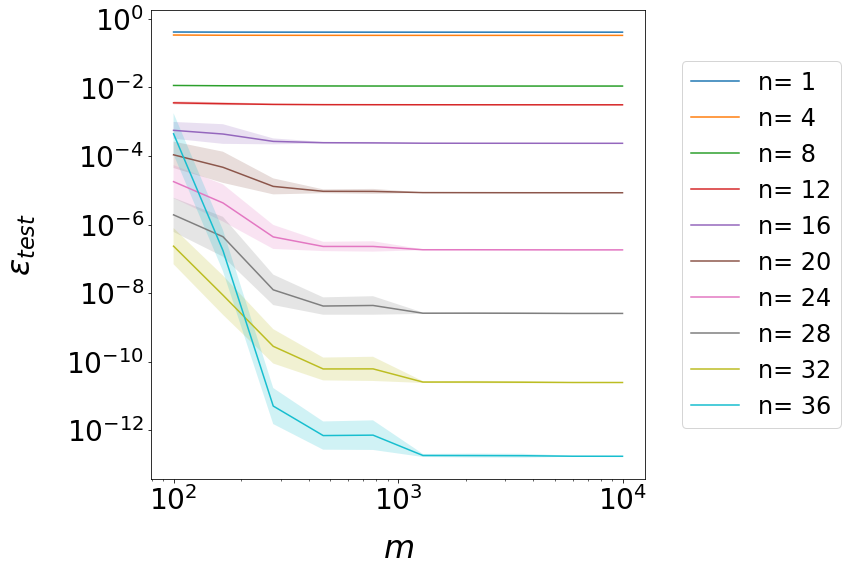

In [21]:
#Plot Error over training set sizes
plt.figure(figsize=(12, 8))  #Size
results_mean = np.mean(MSE, axis = 2)
results_lower = np.std(MSE, axis = 2)/results_mean # 90% confidence intervals


for i in range(len(Para_slep)):
    plt.loglog(Nsamples, results_mean[i,:], label=f'n= {Para_slep[i]}')
    plt.fill_between(Nsamples, results_mean[i,:]/(1+results_lower[i,:]), results_mean[i,:]*(1+results_lower[i,:]),  alpha=0.2)




plt.xlabel(r'$m$', fontsize=32, labelpad=18)
plt.ylabel(r'$\epsilon_{test}$', fontsize=32, labelpad=28)


# Increase font size of axis tick labels
plt.tick_params(axis='both', which='major', labelsize=28)  # Major ticks
plt.tick_params(axis='both', which='minor', labelsize=28)  # Minor ticks

plt.legend(fontsize=28, loc='lower left')

plt.legend(
    fontsize=24,
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),  # Place the legend to the right of the plot
    ncol=1  # Single column for legend entries
)

plt.tight_layout()  


plt.savefig("errorvsparams.pdf")


plt.show()